# Imports

Enable operations to use the cpu if no Apple gpu implementation is available

In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


Reload modules automagically if they change

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import json
import sklearn
import ot
import torch
from sklearn.svm import SVC
from Utils.SVM_utils import test_svm, train_svm
from einops import rearrange
from Utils.visualization_utils import visualize_barycenter_diracs, plot_images, plot_pca_for_arrays
from Utils.joint_OT_mapping_linear_classreg import free_support_sinkhorn_barycenter, compute_joint_OT_mapping
from warnings import catch_warnings
from map_hyperparam import optimize_hyperparams

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

# Data

In [21]:
data_path = '/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/Office-Caltech'

Read the image features

In [22]:
dataset = np.load(os.path.join(data_path, 'Objects_Decaf.npy'))
with open(os.path.join(data_path, 'Objects_crossval_index.json'), 'r') as f:
    fold_dict = json.loads(f.read())

domain_names = ['Webcam', 'Amazon', 'dslr', 'Caltech']

Set the number of classes within each domain

In [23]:
n_classes = 10
standardize = True

In [24]:
dataset.shape

(2533, 4098)

In [25]:
X = dataset[:, :-2]
if standardize:
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
else:
    # Feature scaling
    X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

y = np.array(dataset[:, -2], dtype=int)
m = np.array(dataset[:, -1], dtype=int)
domains = np.unique(m).astype(int)
targets = domains
n_domains = len(domains)

Dataset has shape n_points x n_features

In [26]:
X.shape, y.shape, targets.shape

((2533, 4096), (2533,), (4,))

Visualize some image features as 64x64 images

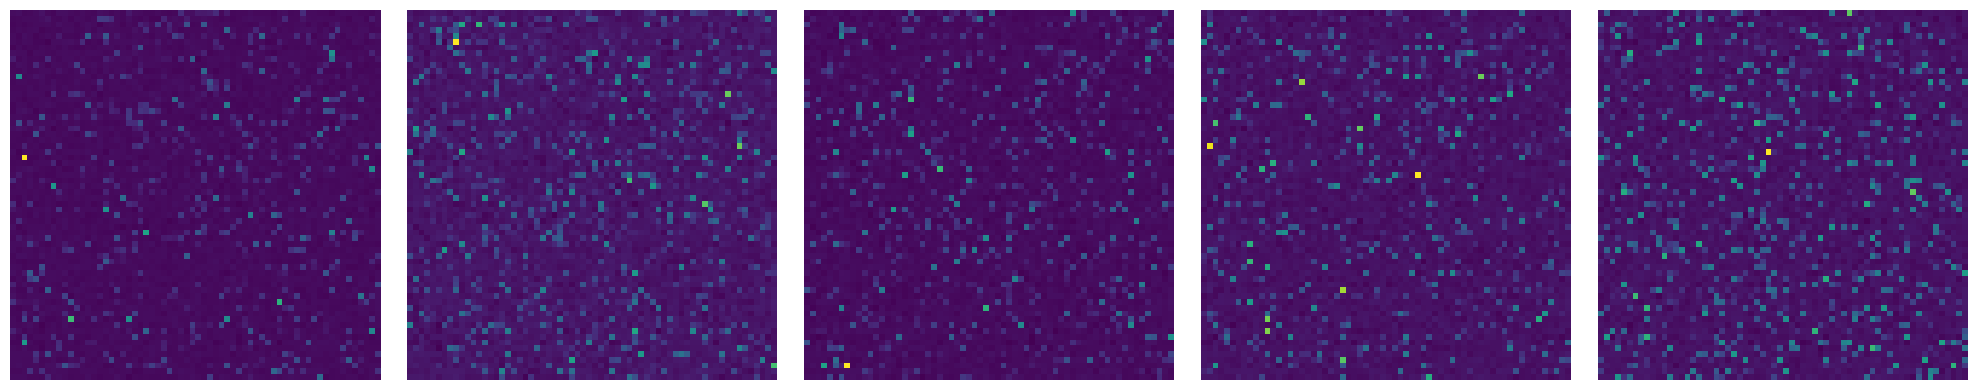

In [27]:
plot_images(X, num_to_plot=5, h=64, w=64)
plt.show()

### Number of samples coming from a given domain, having a given class

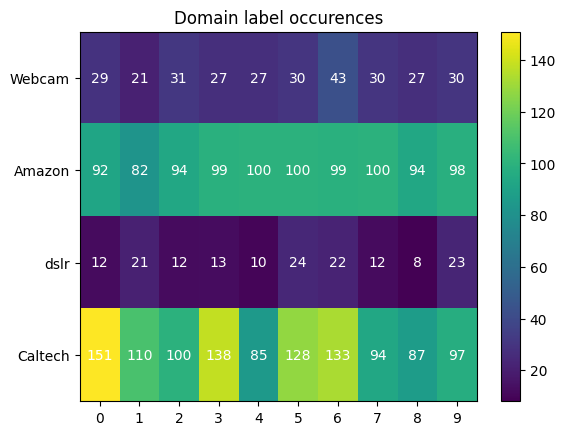

In [28]:
label_domain_occurence = np.zeros((4, 10), dtype=int)
for label in range(10):
    for i, domain in enumerate(domains):
        domain_indices = np.where(m == domain)
        domain_labels = y[domain_indices]
        label_indices = np.where(domain_labels == label+1)
        label_domain_occurence[i][label] = len(label_indices[0])

fig, ax = plt.subplots()
cax = ax.imshow(label_domain_occurence, cmap='viridis', aspect='auto')
for (i, j), val in np.ndenumerate(label_domain_occurence):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white')
fig.colorbar(cax)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(str(i) for i in range(10))
ax.set_yticklabels(domain_names)
plt.title('Domain label occurences')
plt.show()

# Training

Set the number of train samples from every domain. Within each domain, n_train/10 samples are selected from each class, meaning that n_train should be divisible by 10.

In [41]:
X_all = []
y_all = []
for i, domain in enumerate(domains):
    domain_indices = np.where(m == domain)
    X_all.append(torch.tensor(X[domain_indices], dtype=torch.float32, device=device))
    y_all.append(torch.tensor(y[domain_indices], dtype=torch.int, device=device))

In [30]:
X_trains = []
X_tests = []
y_trains = []
y_tests = []

for i in range(len(X_all)):
    X_i = X_all[i].cpu()
    y_i = y_all[i].cpu()
    X_i_train, X_i_test, y_i_train, y_i_test = sklearn.model_selection.train_test_split(X_i, y_i, train_size=0.3, shuffle=True, stratify=y_i, random_state=42)
    X_trains.append(X_i_train.to(device))
    X_tests.append(X_i_test.to(device))
    y_trains.append(y_i_train.to(device))
    y_tests.append(y_i_test.to(device))

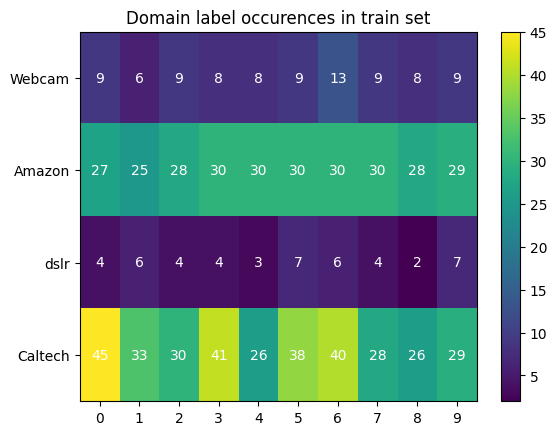

In [39]:
label_domain_occurence = np.zeros((4, 10), dtype=int)
for label in range(10):
    for i in range(n_domains):
        domain_labels = y_trains[i]
        label_indices = np.where(domain_labels == label+1)
        label_domain_occurence[i][label] = len(label_indices[0])

fig, ax = plt.subplots()
cax = ax.imshow(label_domain_occurence, cmap='viridis', aspect='auto')
for (i, j), val in np.ndenumerate(label_domain_occurence):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white')
fig.colorbar(cax)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(str(i) for i in range(10))
ax.set_yticklabels(domain_names)
plt.title('Domain label occurences in train set')
plt.show()

Concatenate the train samples into one tensor

In [14]:
Xs = torch.concatenate(tensors=X_trains, dim=0)
ys = torch.concatenate(y_trains, dim=0)
Xs.shape, ys.shape

(torch.Size([2025, 4096]), torch.Size([2025]))

In [15]:
n_features = 4096

# Compute barycenter

We now consider measures. Each dataset will be considered a measure:

$\mu = \sum a_i \delta_{xi}$

meaning that every image in the dataset is a dirac delta at point $x$, with probability mass of $a_i$. $x$ is the location of the dirac, and it has the coordinates of the flattened image. 

In [16]:
n_bary = np.sum([X_trains[i].shape[0] for i in range(len(X_trains))])

a_i = 1.0 / n_bary
w_i = [torch.ones(X_trains[i].shape[0], dtype=torch.int, device=device) * a_i for i in range(len(X_trains))]

Chose a solver

In [17]:
solvers = ['sinkhorn',
           'sinkhorn_log',
           'greenkhorn',
           'sinkhorn_stabilized',
           'sinkhorn_epsilon_scaling']
solver = solvers[1]
print(f'Method: {solver}')

Method: sinkhorn_log


In [18]:
recompute = False

if not recompute and os.path.exists('barycenter 100 iter.npy'):
    barycenter = np.load('barycenter 100 iter.npy')
    barycenter = torch.tensor(barycenter, dtype=torch.float32, device=device)
    print('Barycenter loaded')
else:
    barycenter, log_dict = free_support_sinkhorn_barycenter(
        measures_locations=X_trains,
        measures_weights=w_i,
        X_init=torch.randn(
            (n_bary, n_features),
            dtype=torch.float32,
            device=device,
        ),
        reg=5.0,
        b=torch.ones((n_bary, ), dtype=torch.float32, device=device) * a_i,
        numItermax=100,
        numInnerItermax=int(1e5),
        verbose=True,
        stopThr=1e-5,
        log=True,
        method=solver
    )
    # Save barycenter if kernel needs to be restarted
    np.save('barycenter.npy', barycenter.cpu())


Barycenter loaded


In [19]:
barycenter.shape

torch.Size([2025, 4096])

Visualize samples from the barycenter distribuiton

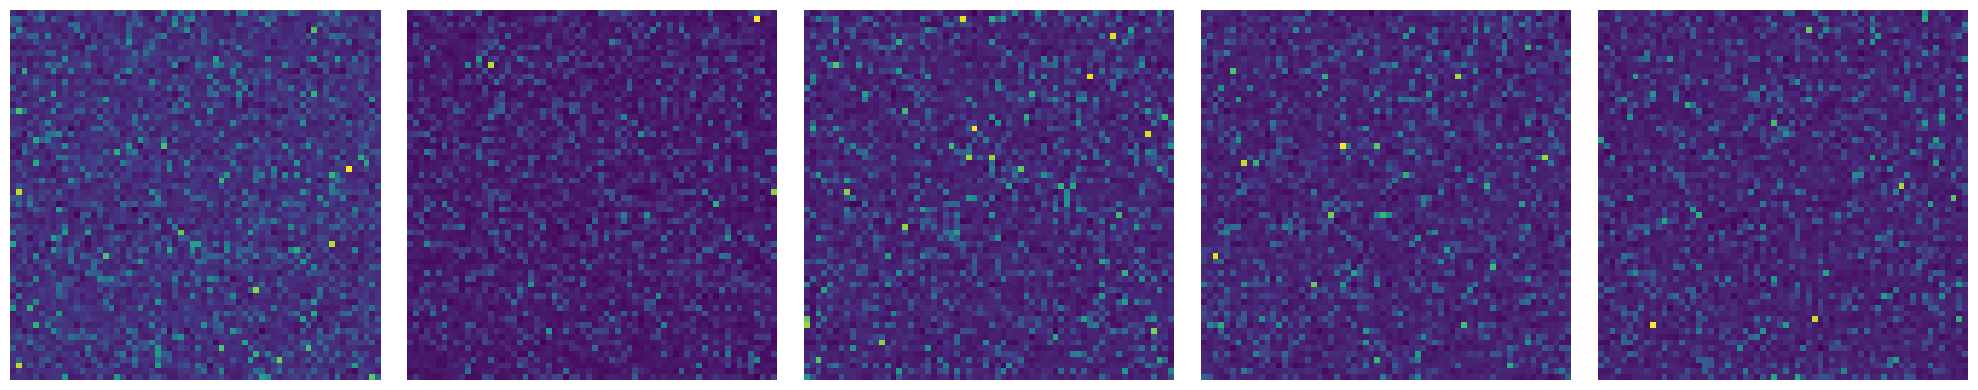

In [20]:
visualize_barycenter_diracs(barycenter.cpu(), num_images=5, random_seed=39)
plt.show()

In [21]:
plot_pca_for_arrays([barycenter.cpu(), X_trains[0].cpu(), X_trains[1].cpu(), X_trains[2].cpu(), X_trains[3].cpu()], n_components=3, labels=['Barycenter', 'Dom 1', 'Dom 2', 'Dom 3', 'Dom 4'])
plt.show()

### Compute coupling matrices (G) and maps (L) from each domain to the barycenter domain

chose a labeling technique

In [22]:
yt = torch.concatenate(y_trains) # Random labeling

In [23]:
model = train_svm(barycenter.cpu(), yt.cpu(), kernel='rbf', C=1.0)
model.fit_status_ == 0

[LibSVM].*
optimization finished, #iter = 476
obj = -265.347165, rho = -0.078003
nSV = 414, nBSV = 305
.*
optimization finished, #iter = 508
obj = -254.612641, rho = 0.138136
nSV = 415, nBSV = 249
.*
optimization finished, #iter = 519
obj = -273.943396, rho = -0.205160
nSV = 447, nBSV = 329
.*
optimization finished, #iter = 465
obj = -265.433538, rho = -0.027581
nSV = 405, nBSV = 292
.*
optimization finished, #iter = 532
obj = -279.836366, rho = 0.235981
nSV = 452, nBSV = 315
.*
optimization finished, #iter = 534
obj = -281.010361, rho = 0.315351
nSV = 463, nBSV = 378
.*
optimization finished, #iter = 469
obj = -269.067302, rho = -0.131057
nSV = 417, nBSV = 318
.*
optimization finished, #iter = 462
obj = -253.142576, rho = 0.235536
nSV = 398, nBSV = 279
.*
optimization finished, #iter = 503
obj = -266.072264, rho = -0.064973
nSV = 426, nBSV = 298
.*
optimization finished, #iter = 504
obj = -241.166453, rho = 0.131793
nSV = 377, nBSV = 244
.*
optimization finished, #iter = 457
obj = -25

True

In [35]:
optimize_hyperparams(X_trains, y_trains, n_features, barycenter, yt, device, model, iter=2)

It.  |Loss        |Delta loss
--------------------------------
    0|7.440872e+02|0.000000e+00
    1|7.440811e+02|-8.202689e-06
    2|7.440749e+02|-8.284784e-06
[0.125      0.1875     0.10526316 0.22222222 0.3125     0.23809524
 0.         0.         0.         0.32258065]
It.  |Loss        |Delta loss
--------------------------------
    0|5.872519e+03|0.000000e+00
    1|3.440871e+03|-4.140723e-01
    2|3.107279e+03|-9.694988e-02
[0.22727273 0.13861386 0.15277778 0.2        0.29411765 0.15
 0.03448276 0.06976744 0.03448276 0.25555556]
It.  |Loss        |Delta loss
--------------------------------
    0|4.028143e+02|0.000000e+00
    1|4.028133e+02|-2.500110e-06
    2|4.028126e+02|-1.894027e-06


KeyboardInterrupt: 

In [27]:
recompute_map = True
if recompute_map:
    G_all = []
    L_all = []
    b_all = []
    
    method = 'gaussian'
    bias = False
    
    for d in range(n_domains):
        print(f'Computing coupling mtx and map from domain {d} -> barycenter.')
        G, L, loss = compute_joint_OT_mapping(xs=X_trains[d].to(device),
                                              xt=barycenter.to(device),
                                              ys=y_trains[d].cpu(),
                                              yt=yt.cpu(),
                                              mu=1e-3,
                                              eta=1e-3,
                                              numItermax=10000,
                                              numInnerItermax=int(1e7),
                                              stopThr=1e-7,
                                              stopInnerThr=1e-7,
                                              method=method,
                                              bias=bias,
                                              class_reg=True)
        
        G_all.append(G)
        # L_all.append(L[0:n_features, :])
        L_all.append(L)
        # b_all.append(L[n_features, :]) # bias
        b_all.append(torch.zeros(size=(n_features,)))
        
        ls = [l.cpu() for l in loss['loss']]
        plt.plot(ls)
        plt.title(f'Loss for domain {d}')
        plt.axis('off')
        
        if method == 'gaussian':
            K = ot.utils.kernel(X_trains[d], X_trains[d], method=method, sigma=1.0)
            if bias:
                K = torch.concatenate([K, torch.ones((Xs.shape[0], 1), dtype=torch.float32)], dim=1)
            
            transp = G / torch.sum(G, 1)[:, None] # standard barycentric mapping
            transp = torch.nan_to_num(transp, nan=0, posinf=0, neginf=0)
            transp_Xtrain = transp.T @ X_trains[d]
            mapped_Xtrain = K @ L
            
            metrics, disp = test_svm(model, mapped_Xtrain.cpu(), y_trains[d].cpu())
            disp.plot()
            print(metrics['accuracy'])
            # test_svm(model, transp_Xtrain.cpu(), y_trains[d].cpu())
            
            plt.show()
        
    plt.tight_layout()
    plt.show()

    # Save G_all, L_all, and b_all
    with open('data.pkl', 'wb') as f:
        pickle.dump({'G_all': G_all, 'L_all': L_all, 'b_all': b_all}, f)

else:
    def load_saved_lists(file_path: str):
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        return data["G_all"], data["L_all"], data["b_all"]
    G_all, L_all, b_all = load_saved_lists("data.pkl")
    print('loaded')

Computing coupling mtx and map from domain 0 -> barycenter.


/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/ot/backend.py:2214: UserWarning:

The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)



It.  |Loss        |Delta loss
--------------------------------
    0|7.440872e+02|0.000000e+00
    1|7.440811e+02|-8.202689e-06
    2|7.440749e+02|-8.284784e-06
    3|7.440686e+02|-8.448909e-06
    4|7.440631e+02|-7.382605e-06
    5|7.440572e+02|-7.956865e-06
    6|7.440510e+02|-8.285049e-06
    7|7.440444e+02|-8.859334e-06
    8|7.440383e+02|-8.203160e-06
    9|7.440323e+02|-8.121195e-06
   10|7.440266e+02|-7.711096e-06
   11|7.440212e+02|-7.136921e-06
   12|7.440154e+02|-7.875279e-06
   13|7.440097e+02|-7.629237e-06
   14|7.440034e+02|-8.531685e-06
   15|7.439973e+02|-8.203613e-06
   16|7.439914e+02|-7.875533e-06
   17|7.439853e+02|-8.203745e-06


KeyboardInterrupt: 

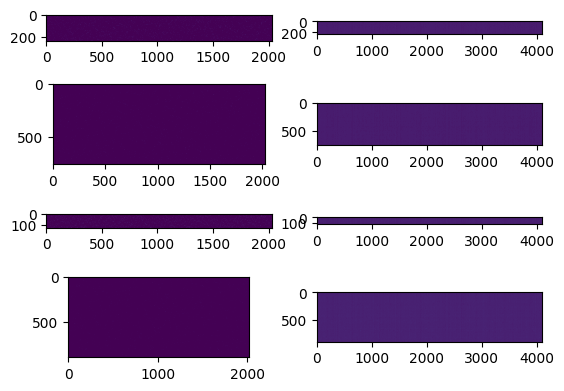

In [52]:
fig, axarr = plt.subplots(n_domains, 2)
for d in range(n_domains):
    axarr[d, 0].imshow(G_all[d].cpu(), cmap='viridis')
    axarr[d, 1].imshow(L_all[d].cpu(), cmap='viridis')
    

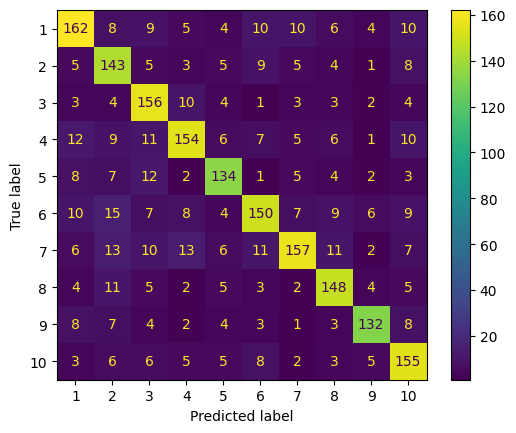

0.7362962962962963


In [43]:
metrics, disp = test_svm(model, barycenter.cpu(), yt.cpu())
disp.plot()
plt.show()
print(metrics['accuracy'])

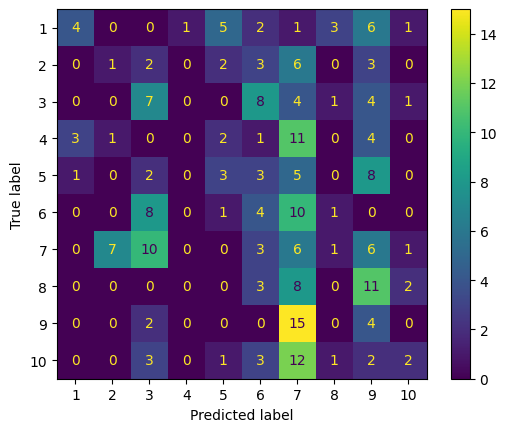

0.13135593220338984


In [44]:
metrics, disp = test_svm(model, X_trains[0].cpu(), y_trains[0].cpu())
disp.plot()
plt.show()
print(metrics['accuracy'])

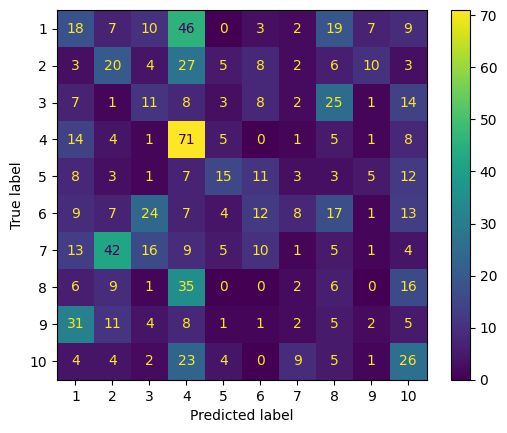

0.2026726057906459


In [54]:
kern = kernel(X_trains[3], X_trains[3])
metrics, disp = test_svm(model, kern.cpu(), y_trains[3].cpu(), L=L_all[3].cpu(), b=b_all[3].cpu())
disp.plot()
plt.show()
print(metrics['accuracy'])